# Лабораторна робота №10. Transfer Learning

**Тема:** Класифікація зображень за допомогою Transfer Learning (MobileNetV2).

**Мета:** Навчитися використовувати попередньо натреновані моделі (TensorFlow Hub) для вирішення задачі бінарної класифікації методом Feature Extraction та Fine-Tuning.

**Датасет:** Власний набір даних (Pizza vs Burger).

In [2]:
!pip install tensorflow-hub


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:

!pip install tf_keras

import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

print("TensorFlow version:", tf.__version__)


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\polina\yniver\Kubiedinova_Data_Analysis\myenv\Lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


TensorFlow version: 2.20.0


In [4]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

# Налаштування шляхів (використовуємо ті ж папки, що і в Лаб 9)
TRAIN_DIR = 'dataset/train'
TEST_DIR = 'dataset/test'

# MobileNetV2 вимагає саме такий розмір [cite: 69]
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

print("Бібліотеки завантажено.")

Бібліотеки завантажено.


In [5]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10, #
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

test_data = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 200 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


## Крок 1: Feature Extraction (Виділення ознак)

In [ ]:

model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

# Завантаження шару Hub
feature_extractor_layer = hub.KerasLayer(
    model_url,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    trainable=False
)

model = models.Sequential([
    feature_extractor_layer,
    layers.Dense(1, activation='sigmoid') 
])

# Компіляція
model.compile(optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [7]:

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=5
)

Epoch 1/5



7/7 [==============================] - 15s 1s/step - loss: 0.6661 - accuracy: 0.6300 - val_loss: 0.5808 - val_accuracy: 0.7250
Epoch 2/5
7/7 [==============================] - 7s 1s/step - loss: 0.5787 - accuracy: 0.7150 - val_loss: 0.5231 - val_accuracy: 0.8250
Epoch 3/5
7/7 [==============================] - 6s 875ms/step - loss: 0.5307 - accuracy: 0.7650 - val_loss: 0.4828 - val_accuracy: 0.8250
Epoch 4/5
7/7 [==============================] - 7s 949ms/step - loss: 0.4601 - accuracy: 0.8800 - val_loss: 0.4436 - val_accuracy: 0.8250
Epoch 5/5
7/7 [==============================] - 7s 1s/step - loss: 0.4270 - accuracy: 0.8850 - val_loss: 0.4127 - val_accuracy: 0.8750


## Етап 2: Fine-Tuning (Донавчання)

In [ ]:
feature_extractor_layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
            loss='binary_crossentropy',
            metrics=['accuracy'])

print("Починаємо Fine-Tuning...")

# Донавчаємо ще 5 епох
history_fine = model.fit(
    train_data,
    validation_data=test_data,
    epochs=5
)

Починаємо Fine-Tuning...
Epoch 1/5
7/7 [==============================] - 85s 10s/step - loss: 0.6562 - accuracy: 0.7050 - val_loss: 0.4981 - val_accuracy: 0.8750
Epoch 2/5
7/7 [==============================] - 32s 5s/step - loss: 0.5753 - accuracy: 0.7750 - val_loss: 0.5012 - val_accuracy: 0.8750
Epoch 3/5
7/7 [==============================] - 33s 5s/step - loss: 0.5283 - accuracy: 0.8250 - val_loss: 0.5018 - val_accuracy: 0.8750
Epoch 4/5
7/7 [==============================] - 38s 5s/step - loss: 0.4853 - accuracy: 0.8700 - val_loss: 0.4960 - val_accuracy: 0.8750
Epoch 5/5
7/7 [==============================] - 33s 4s/step - loss: 0.4305 - accuracy: 0.8850 - val_loss: 0.4895 - val_accuracy: 0.8750


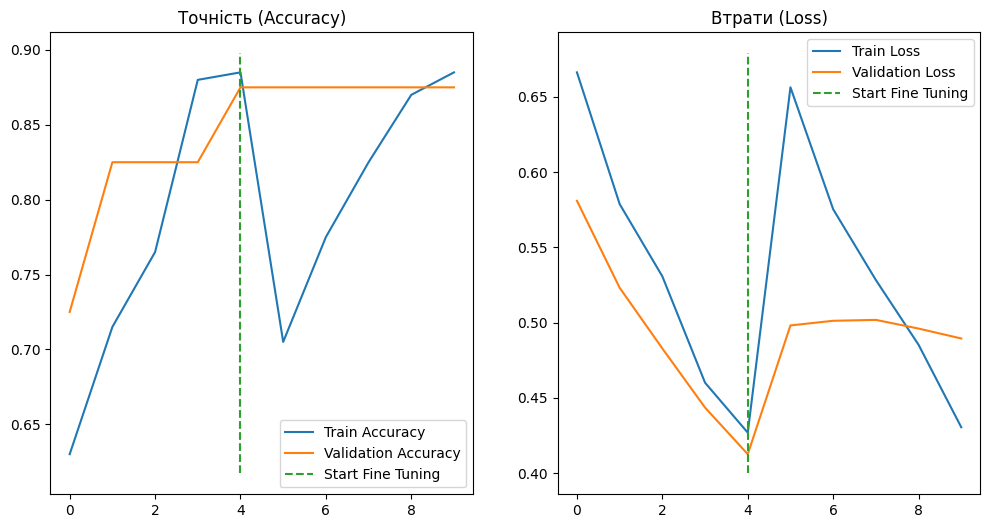

In [9]:
# Об'єднуємо історії навчання (щоб намалювати красивий графік)
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# Малюємо лінію, де почався Fine-Tuning
plt.plot([4, 4], plt.ylim(), label='Start Fine Tuning', linestyle='--')
plt.legend(loc='lower right')
plt.title('Точність (Accuracy)')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([4, 4], plt.ylim(), label='Start Fine Tuning', linestyle='--')
plt.legend(loc='upper right')
plt.title('Втрати (Loss)')
plt.show()

2/2 [==============================] - 6s 731ms/step
              precision    recall  f1-score   support

       green       0.83      0.95      0.88        20
         red       0.94      0.80      0.86        20

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.88      0.88      0.87        40



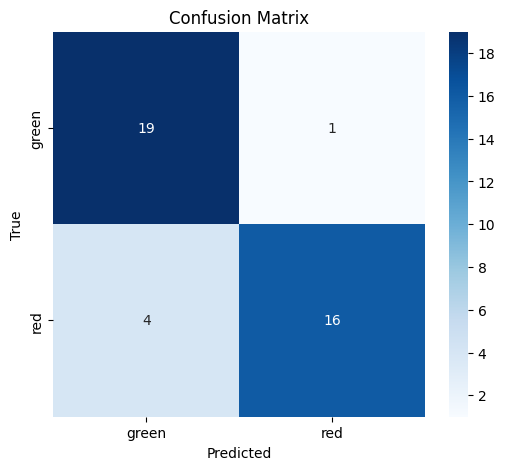

In [10]:
# Отримання прогнозів
test_data.reset()
predictions = model.predict(test_data, steps=len(test_data))
y_pred = (predictions > 0.5).astype("int32")
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Звіт [cite: 51]
print(classification_report(y_true, y_pred, target_names=class_labels))

# Матриця помилок [cite: 90]
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Додаткове завдання: експеримент з гіперпараметрами

In [14]:
learning_rates = [1e-3, 1e-4, 1e-5]
results = []

for lr in learning_rates:
   print(f"\nНавчання з LR={lr}")

   feature_extractor_layer.trainable = True
   model.compile(
      optimizer=tf.keras.optimizers.Adam(lr),
      loss="binary_crossentropy",
      metrics=["accuracy"]
   )
   
   hist = model.fit(train_data, epochs=3, validation_data=test_data)
   acc = max(hist.history["val_accuracy"])
   
   results.append((lr, acc))

print("\nПорівняння:")
for lr, acc in results:
   print(f"LR={lr}: accuracy={acc:.4f}")


Навчання з LR=0.001
Epoch 1/3
7/7 [==============================] - 62s 6s/step - loss: 0.3277 - accuracy: 0.9050 - val_loss: 0.0845 - val_accuracy: 1.0000
Epoch 2/3
7/7 [==============================] - 41s 6s/step - loss: 0.1700 - accuracy: 0.9600 - val_loss: 1.2486 - val_accuracy: 0.8500
Epoch 3/3
7/7 [==============================] - 34s 5s/step - loss: 0.1283 - accuracy: 0.9850 - val_loss: 0.2323 - val_accuracy: 0.9750

Навчання з LR=0.0001
Epoch 1/3
7/7 [==============================] - 56s 5s/step - loss: 0.0927 - accuracy: 1.0000 - val_loss: 0.1812 - val_accuracy: 0.9750
Epoch 2/3
7/7 [==============================] - 33s 5s/step - loss: 0.0848 - accuracy: 1.0000 - val_loss: 0.1487 - val_accuracy: 0.9750
Epoch 3/3
7/7 [==============================] - 27s 4s/step - loss: 0.0846 - accuracy: 1.0000 - val_loss: 0.0996 - val_accuracy: 1.0000

Навчання з LR=1e-05
Epoch 1/3
7/7 [==============================] - 46s 4s/step - loss: 0.0878 - accuracy: 1.0000 - val_loss: 0.0858 